# 4 - Generative Adversarial Network

`github.com/samph4`

~

## Preface

This example will be more in-depth than the first few, but a lot of the principles that we have already applied also apply here. As always, we'll go through it step by step and I'll do my best to explain each part so that it makes sense and is as easy to follow as I can make it. In this final example, we will be looking at Generative Adversarial Networks - affectionately known as GANs. The concept of GANs were first introduced by Ian Goodfellow and his team in 2014 (https://arxiv.org/abs/1406.2661), where they "proposed a new framework for estimating generative models via an an adversarial process". I'll get into this in much more detail, but essentially what is happening here is that we are going to train two neural networks (that will be adversaries), that will compete against one another in order to improve. One will be reffered to as the Discriminator and the other will be known as the Generator. We combine both of these networks to form a combined model known as the GAN for training. Once training has been completed, we want to be able to use the *trained* Generator network independently to generate new things!

![Image](./Figures/gan2.png)

The image above looks rather unassuming, it is simply a row of portraits of four different people. The interesting thing however, is that none of these people actually exist. They are not real. Each of these images has been generated by a Generative Adversarial Network known as StyleGAN. StyleGAN is a sophisticated GAN that has been curated and trained by NVIDIA and represents the state-of-the-art results in data-driven unconditional generative image modelling and is an impressive testament as to the possibilities of Generative Networks. Here is another video that demonstrates the capabilities of these methods (which is only 2 minutes long so I recommend you watch it because it's v cool) - https://www.youtube.com/watch?v=p5U4NgVGAwg. With that being said, lets take a closer look as to how these things actually work.

![Image](./Figures/gan1.png)

~

## Training Set

First of all, we need to decide what we want our generative network to generate. Of course, NVIDIA's sophisticated StyleGAN is capable of generating human faces, but GANs are capable of generating new data regardless of the form that it comes in. GANs can be used to generate new audio signals, new images, new time-series data etc. GANs are capable of generating new data that is representative of the data that it was trained on (the training set). Therefore, in large, a key factor in the success of the GAN model lies in the quality of the training set. 

In this example we will 

`dataset = name of variable containing training set`

```{note}
Throughout this example I may use terms such as 'real' and 'fake' when referring to data. Real refers to data samples that come from the training set and 'fake' samples refer to any data that is produced by the Generator.
```

### Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU

from keras import optimizers
from keras import initializers
from matplotlib import pyplot

Using TensorFlow backend.


### Create Training (Target) Dataset

Here we create a simple dataset that will be used to form the training set of real data. For simplicity, we will consider a simple y=sin(x) function.

In [36]:
np.sqrt(5)

2.23606797749979

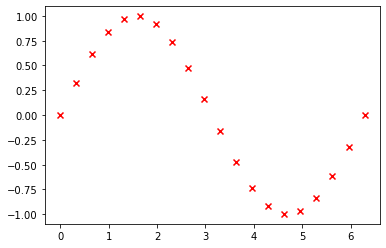

In [48]:
n1 = 20
dataset = np.zeros((n1,2))
dataset[:,0] = np.linspace(0,2*np.pi,n1)
dataset[:,1] = np.sin(dataset[:,0])

pyplot.scatter(dataset[:,0],dataset[:,1], marker='x',color='r')
pyplot.show()

#### Take Real Samples
To evaluate the performance of the GAN we will use the real data from the training set to train the Discriminator so that it can learn the characteristics of data that comes from the training set. This will make it easier for the Discriminator to label samples that come from the Generator as fake. 

In [3]:
def take_real_samples(n):
    np.random.seed(30)
    idx = np.random.randint(len(dataset), size=int(n))
    X = dataset[idx,:]
    y = np.ones((n,1)) 
    
    return X, y

#### Generate points in latent space as input for the generator

Next, we can use the generator model to generate fake samples. Although first we need to generate points in latent space via the `generate_latent_points()` function below. These can then be passed to the generator model and used to generate new samples.

In [4]:
# generate points in latent space as input for the generator
def create_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

#### Use the Generator to generate n fake examples, with class labels

The `generate_fake_samples()` function below inputs the latent variables created by the `generate_latent_points()` function into the generator network to generate n fake samples `X`. Class labels of 0's are assigned to variable `y` to label the fake samples.

In [5]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = create_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

### Define GAN Model

#### Discrimnator

In [31]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Generator

In [7]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

#### Combined GAN Model

In [64]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

## Evaluate Performance

In [53]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = take_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch+1, acc_real, acc_fake)
    # scatter plot real and fake data points
    
    
    pyplot.scatter(x_real[:, 0], x_real[:, 1], marker='x', color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], marker='$\u25EF$', color='grey')
    pyplot.show()

In [51]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=20000, n_batch=1024, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = take_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = create_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

C:\Users\Samuel\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 0.4099999964237213 0.8700000047683716


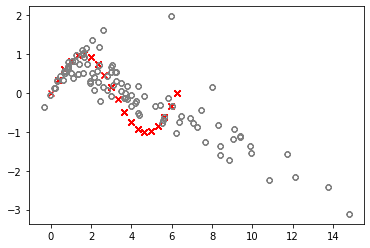

2000 0.7099999785423279 0.6600000262260437


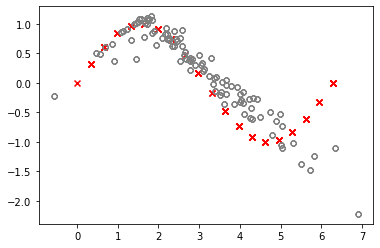

3000 0.47999998927116394 0.7799999713897705


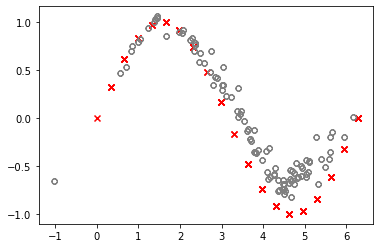

4000 0.23999999463558197 0.8899999856948853


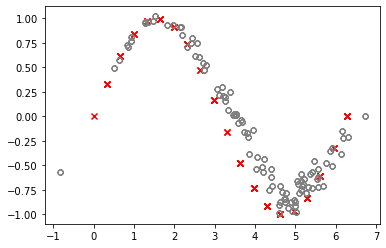

5000 0.23999999463558197 0.8899999856948853


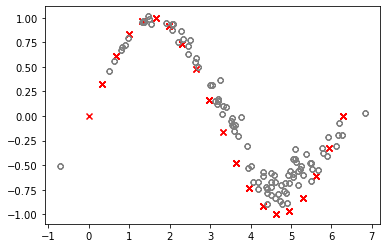

6000 0.23999999463558197 0.8899999856948853


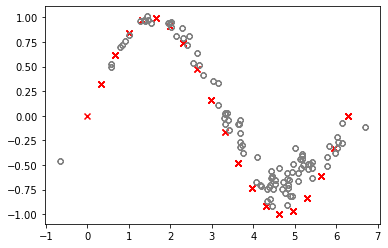

7000 0.3100000023841858 0.9100000262260437


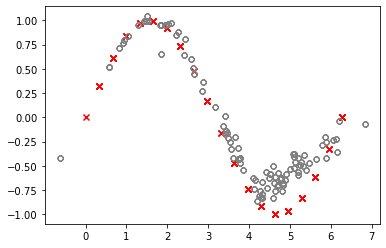

8000 0.3700000047683716 0.9100000262260437


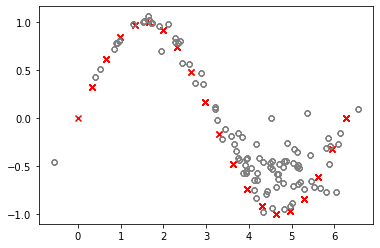

9000 0.4300000071525574 0.8799999952316284


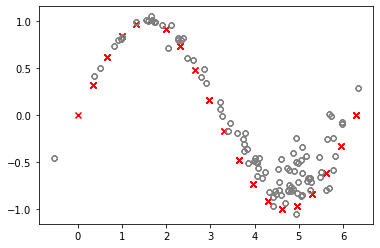

10000 0.4300000071525574 0.8700000047683716


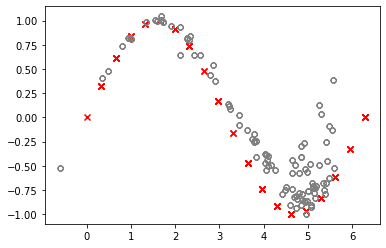

11000 0.4300000071525574 0.8899999856948853


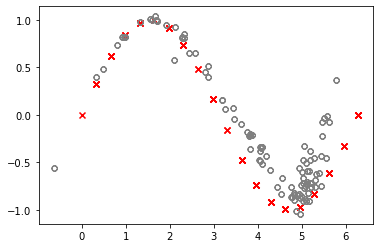

12000 0.4300000071525574 0.8799999952316284


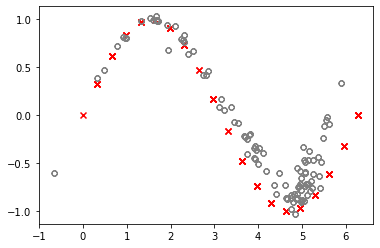

13000 0.4300000071525574 0.8799999952316284


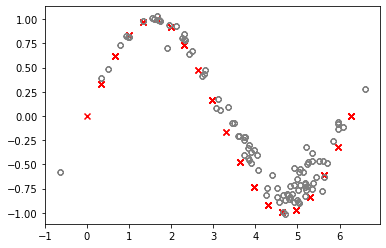

14000 0.4300000071525574 0.8600000143051147


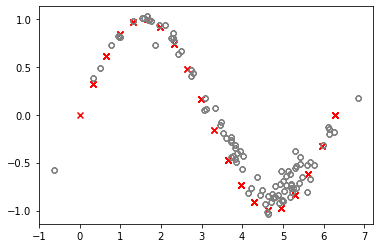

15000 0.4300000071525574 0.8700000047683716


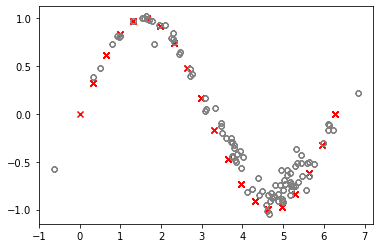

16000 0.4300000071525574 0.8500000238418579


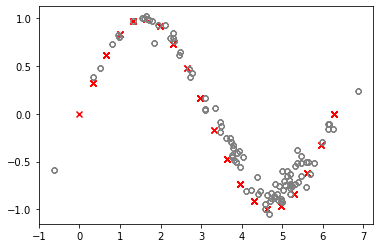

17000 0.46000000834465027 0.8600000143051147


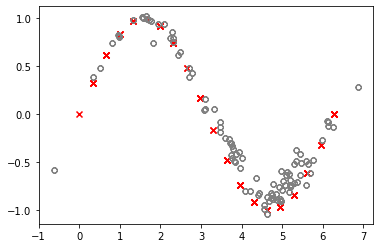

18000 0.46000000834465027 0.8399999737739563


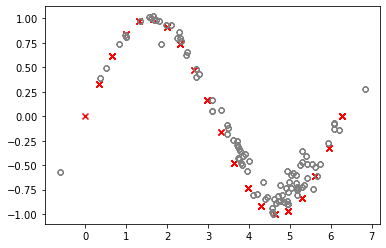

19000 0.4099999964237213 0.8500000238418579


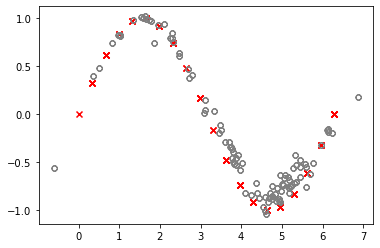

20000 0.4399999976158142 0.8600000143051147


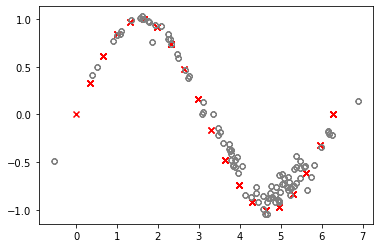

In [65]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)